# LangGraph Basics

Over the course of this notebook, we will build an agentic RAG application using LangGraph with increasing complexity. We will start with a simple RAG flow, and then add conditional branching, loops, memory, human in the loop, and more.

## Pre-work: Setup

You can set your environment variables locally in this notebook.

In [2]:
!pip install -q langchain openai langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.5 MB/s eta 0:00:00


In [30]:
# ✅ 设置环境变量
import os

# OpenAI 兼容接口（你提供的 key 和 endpoint）
os.environ["OPENAI_API_KEY"] = "sxxxxxxxxNt9"
os.environ["OPENAI_API_BASE"] = "http://4xxxxx00/v1/"
os.environ["OPENAI_API_VERSION"] = "2024-05-01-preview"

In [4]:
os.environ["LANGSMITH_API_KEY"] = "xxxxx"  # 可留空或填写你的 LangSmith Key
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "pr-cold-hedgehog-59"

In [ ]:
import os

# Set environment variables
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langgraph-101"

Alternatively, load environment variables from a .env file

In [ ]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env", override=True)

Make sure you've followed the instructions in setup.md if you haven't yet!

Let's confirm that LangSmith tracing is enabled. If for some reason you can't see traces showing up in LangSmith, this is a great helper command to make sure you can trace!

In [5]:
import os
from langsmith import utils

os.environ.get("LANGCHAIN_TRACING_V2")
utils.tracing_is_enabled()

True

Because we're building a RAG application, we're going to create a vector database. The function for this is in utils.py in the studio folder, feel free to take a look if you're curious! We're going to go ahead and index some LangGraph documentation, in reality you can choose any documents you want, and hook up to your production vector store.

Note: If you're using AzureOpenAI instead of OpenAI directly, navigate over to the implementation of `get_langgraph_docs_retriever` and uncomment the relevant code for AzureOpenAI.

You can authenticate to AzureOpenAI with environment variables, or Azure AD.

In [7]:
# 在 Colab 中运行这条命令安装依赖
!pip install -q langchain langchain-community langchain-openai langchain-chroma


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.5 MB/s eta 0:00:00

In [8]:
!pip install -q tiktoken chromadb


In [15]:
from langchain_openai import OpenAIEmbeddings, AzureOpenAIEmbeddings, AzureChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_google_vertexai import ChatVertexAI
from azure.identity import InteractiveBrowserCredential

credential = InteractiveBrowserCredential()

def get_token():
    token = credential.get_token("https://cognitiveservices.azure.com/.default")
    return token.token

# For AzureOpenAI, make sure you set AZURE_OPENAI_API_KEY and AZURE_OPENAI_ENDPOINT


"""
Embedding Models
"""

OPENAI_EMBEDDING_MODEL = OpenAIEmbeddings()

# Azure OpenAI: Using Environment Variables
# AZURE_OPENAI_EMBEDDING_MODEL = AzureOpenAIEmbeddings(
#     model="text-embedding-3-large",
# )

# Azure OpenAI: Using Azure AD
# AZURE_OPENAI_EMBEDDING_MODEL = AzureOpenAIEmbeddings(
#     openai_api_version="2024-03-01-preview",
#     azure_endpoint="https://deployment.openai.azure.com/",
#     model="text-embedding-3-large",
#     azure_ad_token_provider=get_token
# )


"""
Chat Models
"""
# Azure OpenAI: Using Environment Variables
# AZURE_OPENAI_GPT_4O = AzureChatOpenAI(
#     azure_deployment="gpt-4o",
#     streaming=True
# )

# Azure OpenAI: Using Azure AD
# AZURE_OPENAI_GPT_4O = AzureChatOpenAI(
#     api_version="2024-03-01-preview",
#     azure_endpoint="https://deployment.openai.azure.com/",
#     azure_deployment="gpt-4o",
#     azure_ad_token_provider=get_token
# )

# Anthropic Sonnet 3.5
# ANTHROPIC_SONNET_3_5 = ChatAnthropic(
#     model="claude-3-5-sonnet-20240620",
#     streaming=True
# )

# Vertex AI Gemini 1.5 Flash
# VERTEX_AI_GEMINI_1_5_FLASH = ChatVertexAI(
#     model="gemini-1.5-flash-002",
#     streaming=True
# )

NameError: name 'InteractiveBrowserCredential' is not defined

我将为这段代码添加详细的注释，解释每个部分的功能和使用方法。以下是添加了注释的代码：

```python
import os
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import nest_asyncio
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
# 注意：可调整此导入以使用不同的嵌入模型
from models import OPENAI_EMBEDDING_MODEL as EMBEDDING_MODEL

# LangGraph文档的URL列表，包含教程和概念说明
LANGGRAPH_DOCS = [
    "https://langchain-ai.github.io/langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/",
    "https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/",
    "https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/",
    "https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/",
    "https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo/",
    "https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/",
    "https://langchain-ai.github.io/langgraph/concepts/high_level/",
    "https://langchain-ai.github.io/langgraph/concepts/low_level/",
    "https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/",
    "https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/",
    "https://langchain-ai.github.io/langgraph/concepts/multi_agent/",
    "https://langchain-ai.github.io/langgraph/concepts/persistence/",
    "https://langchain-ai.github.io/langgraph/concepts/streaming/",
    "https://langchain-ai.github.io/langgraph/concepts/faq/"
]

def get_langgraph_docs_retriever():
    """
    创建或加载LangGraph文档的向量检索器
    
    如果本地已存在向量存储，则直接加载；否则从URL获取文档，
    进行分块、嵌入，然后存储到向量数据库中。
    
    Returns:
        retriever: 配置好的向量检索器，lambda_mult=0表示使用相似度搜索
    """
    # 如果指定路径存在向量存储，则直接加载
    if os.path.exists("langgraph-docs-db"):
        print("Loading vectorstore from disk...")
        vectorstore = Chroma(
            collection_name="langgraph-docs",
            embedding_function=EMBEDDING_MODEL,
            persist_directory="langgraph-docs-db"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # 否则，从网络加载文档并创建新的向量存储
    print("Downloading documents and creating vectorstore...")
    # 并行加载所有文档
    docs = [WebBaseLoader(url).load() for url in LANGGRAPH_DOCS]
    # 展平嵌套列表
    docs_list = [item for sublist in docs for item in sublist]
    # 使用基于tiktoken的递归文本分割器，每个块200token，无重叠
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=200, chunk_overlap=0
    )
    # 分割文档
    doc_splits = text_splitter.split_documents(docs_list)
    # 创建Chroma向量存储
    vectorstore = Chroma(
        collection_name="langgraph-docs",
        embedding_function=EMBEDDING_MODEL,
        persist_directory="langgraph-docs-db"
    )
    # 添加文档到向量存储
    vectorstore.add_documents(doc_splits)
    # 持久化到磁盘
    vectorstore.persist()
    print("Vectorstore created and persisted to disk")
    return vectorstore.as_retriever(lambda_mult=0)

def show_graph(graph, xray=False):
    """
    显示LangGraph的Mermaid流程图，带有故障恢复机制
    
    尝试使用默认渲染器，如果失败则回退到pyppeteer渲染
    
    Args:
        graph: 具有get_graph()方法的LangGraph对象
        xray: 是否启用X射线模式，显示更多详细信息
    
    Returns:
        IPython.display.Image: 渲染后的流程图图像
    """
    try:
        # 尝试使用默认渲染方法
        return Image(graph.get_graph(xray=xray).draw_mermaid_png())
    except Exception as e:
        # 如果默认方法失败，回退到pyppeteer
        print(f"Default renderer failed: {str(e)}, falling back to pyppeteer.")
        # 应用nest_asyncio以允许在Jupyter中运行异步代码
        nest_asyncio.apply()
        # 使用pyppeteer渲染方法
        return Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))
```

### 代码说明

这段代码主要实现了两个功能：

1. **文档检索器构建**：
   - `get_langgraph_docs_retriever()` 函数负责管理LangGraph文档的向量存储
   - 支持从本地磁盘加载现有向量存储，或从网络获取文档并创建新的向量存储
   - 使用递归文本分割器将文档拆分为合适的块大小
   - 使用指定的嵌入模型将文本转换为向量表示

2. **流程图渲染**：
   - `show_graph()` 函数用于可视化LangGraph流程图
   - 提供了故障恢复机制，当默认渲染方法失败时自动切换到pyppeteer渲染
   - 支持xray模式，可以显示更详细的流程信息

这个代码模块为使用LangGraph文档进行问答或其他自然语言处理任务提供了基础支持。

In [12]:
import os
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import nest_asyncio
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
# NOTE: Adjust this import to use a different embedding model
from models import OPENAI_EMBEDDING_MODEL as EMBEDDING_MODEL

LANGGRAPH_DOCS = [
    "https://langchain-ai.github.io/langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/",
    "https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/",
    "https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/",
    "https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/",
    "https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo/",
    "https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/",
    "https://langchain-ai.github.io/langgraph/concepts/high_level/",
    "https://langchain-ai.github.io/langgraph/concepts/low_level/",
    "https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/",
    "https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/",
    "https://langchain-ai.github.io/langgraph/concepts/multi_agent/",
    "https://langchain-ai.github.io/langgraph/concepts/persistence/",
    "https://langchain-ai.github.io/langgraph/concepts/streaming/",
    "https://langchain-ai.github.io/langgraph/concepts/faq/"
]

def get_langgraph_docs_retriever():
    # If there is a vectorstore at this path, early return as it is already persisted
    if os.path.exists("langgraph-docs-db"):
        print("Loading vectorstore from disk...")
        vectorstore = Chroma(
            collection_name="langgraph-docs",
            embedding_function=EMBEDDING_MODEL,
            persist_directory="langgraph-docs-db"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, load the documents and persist to the vectorstore
    docs = [WebBaseLoader(url).load() for url in LANGGRAPH_DOCS]
    docs_list = [item for sublist in docs for item in sublist]
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=200, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(docs_list)
    vectorstore = Chroma(
        collection_name="langgraph-docs",
        embedding_function=EMBEDDING_MODEL,
        persist_directory="langgraph-docs-db"
    )
    vectorstore.add_documents(doc_splits)
    print("Vectorstore created and persisted to disk")
    return vectorstore.as_retriever(lambda_mult=0)

def show_graph(graph, xray=False):
    """Display a LangGraph mermaid diagram with fallback rendering.

    Handles timeout errors from mermaid.ink by falling back to pyppeteer.

    Args:
        graph: The LangGraph object that has a get_graph() method
    """
    from IPython.display import Image
    try:
        # Try the default renderer first
        return Image(graph.get_graph(xray=xray).draw_mermaid_png())
    except Exception as e:
        # Fall back to pyppeteer if the default renderer fails
        import nest_asyncio
        nest_asyncio.apply()
        from langchain_core.runnables.graph import MermaidDrawMethod
        return Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

ModuleNotFoundError: No module named 'models'

In [ ]:
from utils import get_langgraph_docs_retriever


In [57]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [64]:
def get_langgraph_docs_retriever():
    # If there is a vectorstore at this path, early return as it is already persisted
    if os.path.exists("langgraph-docs-db"):
        print("Loading vectorstore from disk...")
        vectorstore = Chroma(
            collection_name="langgraph-docs",
            embedding_function=EMBEDDING_MODEL,
            persist_directory="langgraph-docs-db"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, load the documents and persist to the vectorstore
    docs = [WebBaseLoader(url).load() for url in LANGGRAPH_DOCS]
    docs_list = [item for sublist in docs for item in sublist]
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=200, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(docs_list)
    vectorstore = Chroma(
        collection_name="langgraph-docs",
        embedding_function=EMBEDDING_MODEL,
        persist_directory="langgraph-docs-db"
    )
    vectorstore.add_documents(doc_splits)
    print("Vectorstore created and persisted to disk")
    return vectorstore.as_retriever(lambda_mult=0)


In [69]:
from langchain_openai import OpenAIEmbeddings, AzureOpenAIEmbeddings, AzureChatOpenAI





"""
Embedding Models
"""

EMBEDDING_MODEL = OpenAIEmbeddings()



In [70]:
retriever = get_langgraph_docs_retriever()

Loading vectorstore from disk...


I like to clean up the logs to make them easier to read.

In [32]:
import logging

# Suppress HTTP request logs
logging.getLogger("httpx").setLevel(logging.WARNING)  # For httpx
logging.getLogger("requests").setLevel(logging.WARNING)  # For requests
logging.getLogger("openai").setLevel(logging.WARNING)  # For OpenAI API

## Pre-work: Background Concepts

Feel free to skip this section if you're already familiar with the LangChain ChatModel and Messages concepts.

In this course, we'll be using [Chat Models](https://python.langchain.com/v0.2/docs/concepts/#chat-models), which take a sequence of messages as inputs and return chat messages as outputs. By default, the course will use [ChatOpenAI](https://python.langchain.com/v0.2/docs/integrations/chat/openai/) because it is both popular and performant.

Let's instantiate a Chat Model using ChatOpenAI! We use gpt-4o because it is a good balance of speed and quality, but feel free to use other models like gpt-3.5-turbo.

In [38]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Note: If you are using another `ChatModel`, you can define it in `models.py` and import it here
# from models import AZURE_OPENAI_GPT_4O
# llm = AZURE_OPENAI_GPT_4O

Chat models in LangChain have a number of [default methods](https://python.langchain.com/v0.2/docs/concepts/#runnable-interface). For now we'll use `invoke`, which call the model on an input.

Chat models take [messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as input. LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. Let's create a list of messages.

In [39]:
from langchain_core.messages import AIMessage, HumanMessage

# Some sample messages about orcas
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


The ChatModel interface is consistent across all chat models and models are typically initialized once at the start up each notebooks. The benefit here is that you can easily switch between models without changing the downstream code if you have strong preference for another provider.

Let's run our ChatModel on these Messages now!

ChatModel接口在所有聊天模型中是一致的，并且模型通常在启动每个笔记本时初始化一次。这样做的好处是，如果您对另一个提供者有强烈的偏好，您可以轻松地在模型之间切换，而无需更改下游代码。现在让我们在这些消息上运行ChatModel ！

In [36]:
print(llm)

client=<openai.resources.chat.completions.completions.Completions object at 0x7da0fbe6a490> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7da0fbe6af10> root_client=<openai.OpenAI object at 0x7da0fab07f90> root_async_client=<openai.AsyncOpenAI object at 0x7da1018d2250> model_name='gpt-4-o-mini' temperature=0.0 model_kwargs={} openai_api_key=SecretStr('**********') openai_api_base='http://47.84.70.98:9000/v1/'


In [40]:
llm.invoke(messages)

AIMessage(content="One of the best places to see orcas in the U.S. is the Pacific Northwest, particularly around the San Juan Islands in Washington State. The waters surrounding these islands are home to resident orca pods, especially the Southern Resident Killer Whales. \n\nAnother excellent location is the waters off the coast of Alaska, where transient orcas can often be spotted. Places like Kenai Fjords National Park and Glacier Bay National Park are popular for orca watching.\n\nAdditionally, you can also see orcas in California, particularly around Monterey Bay, where they are sometimes spotted during their migration.\n\nIf you're planning a trip, consider going during the summer months (May to September) when orca sightings are more frequent. There are also various whale-watching tours available in these areas that can enhance your chances of seeing these magnificent creatures.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 166, 'p

## Part 1: LangGraph Basics

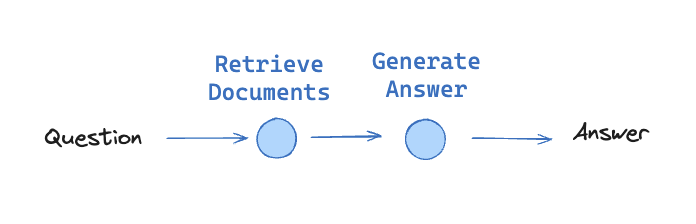



We're going to set up a simple RAG workflow while introducing several LangGraph concepts. We're then going to step into LangSmith and see how it can help us while we iterate on our application

### State

Great, now that we've tested out our ChatModel on some Messages let's start learning about some of our Agent primitives. Our first concept is [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

State is one of the most important concepts in an Agent. When defining a Graph, you must pass in a schema for State. The State schema serves as the input schema for all Nodes and Edges in the graph. Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

The State of our RAG application will keep track of the user's question, our RAG app's LLM generated response, and the list of retrieved relevant documents.

很好，现在我们已经在一些消息上测试了ChatModel，让我们开始学习一些Agent原语。我们的第一个概念是State。状态是Agent中最重要的概念之一。在定义Graph时，必须为State传递模式。状态模式作为图中所有节点和边缘的输入模式。让我们使用python类型模块中的TypedDict类作为模式，它为键提供类型提示。我们的RAG应用程序的状态将跟踪用户的问题、我们的RAG应用程序的LLM生成的响应以及检索到的相关文档的列表。

In [41]:
from langchain.schema import Document
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Attributes:
        question: The user's question
        generation: The LLM's generation
        documents: List of helpful documents retrieved by the RAG pipeline
    """
    question: str
    generation: str
    documents: List[Document]

### Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions. As mentioned above, Nodes take in your graph's State as input.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access each key in the state, in our case, we could use `state["question"]`.
  
Nodes return any updates to the state that they want to make. By default, the new value returned by each node will override the prior state value. You can implement custom handling for updates to State using State Reducers, which we will see later in the session.

Here, we're going to set up two nodes for our RAG flow:
1. retrieve_documents: Retrieves documents from our vector store
2. generate_response: Generates an answer from our documents

节点只是python函数。如上所述，节点将图的State作为输入。第一个位置参数是如上所定义的状态。因为状态是上面定义的具有模式的TypedDict，所以每个节点都可以访问状态中的每个键，在我们的例子中，我们可以使用state["question"]。节点返回它们想要进行的状态的任何更新。默认情况下，每个节点返回的新值将覆盖先前的状态值。你可以使用State Reducers实现对State更新的自定义处理，我们将在后面的会话中看到。这里，我们将为我们的RAG流设置两个节点：检索_documents：从vector storegenerate中检索文档_response：从我们的文档中生成答案

In [42]:
from langchain_core.messages import HumanMessage

def retrieve_documents(state: GraphState):
    """
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents}

RAG_PROMPT = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.

Question: {question}
Context: {context}
Answer:"""

def generate_response(state: GraphState):
    """
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    # Invoke our LLM with our RAG prompt
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation}

### Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) define how your agentic applications progresses from each Node to the next Node.
- Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.
- [Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) are used want to *optionally* route between nodes.

Conditional edges are implemented as functions that return the next node to visit based upon some logic. Note that these functions often use values from our graph's State to determine how to traverse.

We'll add some useful conditional edges later, but for now let's take a look at an example.

EdgesEdges

定义了代理应用程序如何从每个节点进展到下一个节点。如果你想总是从，例如，节点出发，则使用法线边_1到节点_2.条件边用于有选择地在节点之间路由。条件边是作为函数实现的，它根据某些逻辑返回下一个要访问的节点。注意，这些函数经常使用图的State中的值来决定如何遍历。稍后我们将添加一些有用的条件边，但现在让我们看一个示例。

In [43]:
from typing import Literal

def conditional_edge_example(state) -> Literal["node_1", "node_2"]:
    # Often, we will use state to decide on the next node to visit
    field_1 = state['field_1']
    field_2 = state['field_2']
    if field_1 > field_2:
        return "node_1"
    return "node_2"

### Graph

Great! We now have defined the schema for our State, written logic for two Nodes, and learned about Edges. Let's stitch those components together to define our simple RAG graph

First, we instantiate a graph builder with our State. The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.

太棒了!现在，我们已经为状态定义了模式，为两个节点编写了逻辑，并了解了edge。让我们将这些组件拼接在一起来定义简单的RAG graph1。首先，我们用State实例化一个图形构建器。StateGraph类是我们可以使用的图形类。

In [44]:
from langgraph.graph import StateGraph
graph_builder = StateGraph(GraphState)

Next, we add our two defined nodes to our Graph.

In [45]:
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)

We then define the shape of our graph by adding edges between the nodes.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.

The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node.

In [ ]:
from utils import show_graph

In [68]:
from langchain_openai import OpenAIEmbeddings, AzureOpenAIEmbeddings, AzureChatOpenAI





"""
Embedding Models
"""

EMBEDDING_MODEL = OpenAIEmbeddings()



In [52]:
import os
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import nest_asyncio
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
# NOTE: Adjust this import to use a different embedding model


LANGGRAPH_DOCS = [
    "https://langchain-ai.github.io/langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/",
    "https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/",
    "https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/",
    "https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/",
    "https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo/",
    "https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/",
    "https://langchain-ai.github.io/langgraph/concepts/high_level/",
    "https://langchain-ai.github.io/langgraph/concepts/low_level/",
    "https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/",
    "https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/",
    "https://langchain-ai.github.io/langgraph/concepts/multi_agent/",
    "https://langchain-ai.github.io/langgraph/concepts/persistence/",
    "https://langchain-ai.github.io/langgraph/concepts/streaming/",
    "https://langchain-ai.github.io/langgraph/concepts/faq/"
]

def get_langgraph_docs_retriever():
    # If there is a vectorstore at this path, early return as it is already persisted
    if os.path.exists("langgraph-docs-db"):
        print("Loading vectorstore from disk...")
        vectorstore = Chroma(
            collection_name="langgraph-docs",
            embedding_function=EMBEDDING_MODEL,
            persist_directory="langgraph-docs-db"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, load the documents and persist to the vectorstore
    docs = [WebBaseLoader(url).load() for url in LANGGRAPH_DOCS]
    docs_list = [item for sublist in docs for item in sublist]
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=200, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(docs_list)
    vectorstore = Chroma(
        collection_name="langgraph-docs",
        embedding_function=EMBEDDING_MODEL,
        persist_directory="langgraph-docs-db"
    )
    vectorstore.add_documents(doc_splits)
    print("Vectorstore created and persisted to disk")
    return vectorstore.as_retriever(lambda_mult=0)

def show_graph(graph, xray=False):
    """Display a LangGraph mermaid diagram with fallback rendering.

    Handles timeout errors from mermaid.ink by falling back to pyppeteer.

    Args:
        graph: The LangGraph object that has a get_graph() method
    """
    from IPython.display import Image
    try:
        # Try the default renderer first
        return Image(graph.get_graph(xray=xray).draw_mermaid_png())
    except Exception as e:
        # Fall back to pyppeteer if the default renderer fails
        import nest_asyncio
        nest_asyncio.apply()
        from langchain_core.runnables.graph import MermaidDrawMethod
        return Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

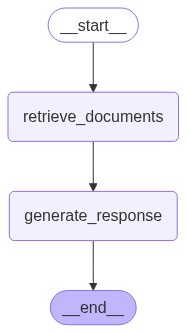

In [53]:
from langgraph.graph import START, END


graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
show_graph(simple_rag_graph)

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure.

最后，我们编译图，对图结构执行一些基本检查。

### Running our Graph

Now that our graph is defined, let's invoke it!

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol. This provides a standard way to execute LangChain components. `invoke` is one of the standard methods in this interface.

The input is a dictionary `{"question": "Does LangGraph work with OSS LLMs"}`, which sets the initial value for our graph's state dictionary. Note that we didn't need to pass in all of the keys of our dictionary.

Our graph executes as follows:
1. When `invoke` is called, the graph starts execution from the `START` node.
2. It progresses to `retrieve_documents` and invokes our retriever on the `question` defined in our State. It then writes the retrieved `documents` to State.
3. It progresses to `generate_response` and makes an LLM call to generate an answer, using our retrieved `documents`.
4. Finally, it progresses to the `END` node.

Each node function receives the current state and returns a new value, which overrides the graph state.

现在我们的图已经定义好了，让我们调用它！编译后的图实现了可运行协议。这提供了一种执行LangChain组件的标准方法。Invoke是这个接口中的标准方法之一。输入是一个字典{"question": "Does LangGraph work with OSS LLMs"}，它为我们的图的状态字典设置了初始值。注意，我们不需要传入字典的所有键。我们的图执行如下：调用invoke时，图从START节点开始执行。它会逐渐恢复_文档并调用在State中定义的问题上的检索器。然后将检索到的文档写入State。它会产生_响应，并使用检索到的文档进行LLM调用以生成答案。最后，它进展到END节点。每个节点函数接收当前状态并返回一个新值，该值覆盖图形状态。

In [71]:
question = "Does LangGraph work with OSS LLMs?"
simple_rag_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GENERATE RESPONSE---


{'question': 'Does LangGraph work with OSS LLMs?',
 'generation': AIMessage(content='Yes, LangGraph works with OSS (Open Source Software) LLMs (Large Language Models). It is designed to be compatible with various open-source models. This allows users to leverage the capabilities of OSS LLMs within the LangGraph framework.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 74, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_57db37749c', 'id': 'chatcmpl-BlpHD14rBfl5rUUESIybBu7cfjiTQ', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--ff1a064c-cc39-4402-8e4e-a1b7f439eb76-0', usage_metadata={'input_tokens': 74, 'output_tokens': 51, 'total_tokens': 125, 'input_t

Congrats on running your first LangGraph application! `invoke` runs the entire graph synchronously. This waits for each step to complete before moving to the next. It returns the final state of the graph after all nodes have executed, which is what we see above.

Let's take a look in LangSmith!

祝贺您运行了第一个LangGraph应用程序！Invoke以同步方式运行整个图。在移动到下一个步骤之前等待每个步骤完成。它返回所有节点执行后图的最终状态，即我们在上面看到的。让我们看一看LangSmith！

## Part 2: Control Flow with Conditional Edges and Loops

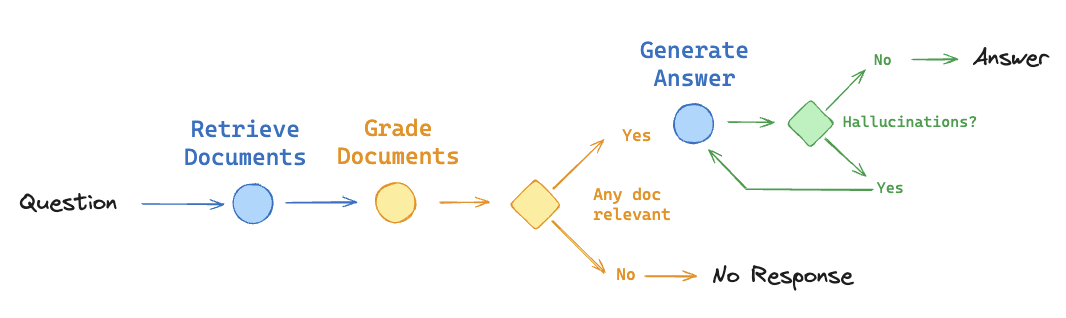


![Corrective RAG](../images/check_hallucinations.png)

In this section, we're going to add a few techniques that can improve our RAG workflow. Specifically, we'll introduce
- Document Grading: Are the documents fetched by the retriever actually relevant to the user's question?
- Hallucination Checking: Is our generated answer actually grounded in the documents?

We're also going to add some constraints to the inputs and outputs of our application for the best user experience.

By the end of this section, we'll have a more complex corrective RAG workflow! Then, we'll hop into LangSmith and walk through how we can evaluate that our application is actually improving as we add new techniques.

在本节中，我们将添加一些可以改进RAG工作流的技术。具体来说，我们将介绍文档分级：检索器获取的文档是否与用户的问题相关？幻觉检查：我们生成的答案实际上是基于文件吗？为了获得最佳的用户体验，我们还将向应用程序的输入和输出添加一些约束。在本节结束时，我们将有一个更复杂的纠正RAG工作流程！然后，我们将进入LangSmith，并通过添加新技术来评估我们的应用程序实际上正在改进。

### Structured Outputs

Some LLMs provide support for Structured Outputs, which provides a typing guarantee for the output schema of the LLM's response. Here, we can use BaseModel from pydantic to define a specific return type. The provided description helps the LLM generate the value for the field.

We can hook this up to our previously defined `llm` using `with_structured_output`. Now, when we invoke our `grade_documents_llm`, we can expect the returned object to contain the expected field.

一些LLM提供对结构化输出的支持，这为LLM响应的输出模式提供了类型保证。在这里，我们可以使用pydantic的BaseModel来定义一个特定的返回类型。提供的描述帮助LLM生成该字段的值。我们可以使用with将它连接到之前定义的llm_结构化_输出。现在，当我们调用我们的分数_文档_嗯，我们可以期望返回的对象包含期望的字段。

In [72]:
from pydantic import BaseModel, Field

class GradeDocuments(BaseModel):
    is_relevant: bool = Field(
        description="The document is relevant to the question, true or false"
    )

grade_documents_llm = llm.with_structured_output(GradeDocuments)
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score true or false to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"

In [73]:
from langchain_core.messages import SystemMessage

def grade_documents(state):
    """
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---GRADE DOCUMENTS---")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    for d in documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.is_relevant
        if grade:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}

Let's make sure that at least some documents are relevant if we are going to respond to the user! To do this, we need to add a conditional edge. Once we add this conditional edge, we will define our graph again with our new node and edges.

In [74]:
def decide_to_generate(state):
    """
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---"
        )
        return "none relevant"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "some relevant"

Let's put our graph together!

In [76]:
def show_graph(graph, xray=False):
    """Display a LangGraph mermaid diagram with fallback rendering.

    Handles timeout errors from mermaid.ink by falling back to pyppeteer.

    Args:
        graph: The LangGraph object that has a get_graph() method
    """
    from IPython.display import Image
    try:
        # Try the default renderer first
        return Image(graph.get_graph(xray=xray).draw_mermaid_png())
    except Exception as e:
        # Fall back to pyppeteer if the default renderer fails
        import nest_asyncio
        nest_asyncio.apply()
        from langchain_core.runnables.graph import MermaidDrawMethod
        return Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

In [ ]:
from utils import show_graph

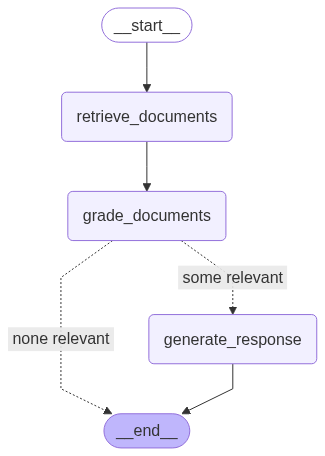

In [77]:
from langgraph.graph import StateGraph
from langgraph.graph import START, END


graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)    # new node!
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")    # edited edge
graph_builder.add_conditional_edges(    # new conditional edge
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_edge("generate_response", END)

document_grading_graph = graph_builder.compile()
show_graph(document_grading_graph)

Let's try to invoke our graph again, this time with a question about something totally irrelevant, like pokemon.

In [78]:
question = "What is your favorite pokemon?"
document_grading_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---


{'question': 'What is your favorite pokemon?', 'documents': []}

### Hallucination Checking with a Loop

幻觉循环检查

Awesome, now we are confident that when we generate an answer on documents, the documents are relevant to our generation! However, we're still not sure if the LLM's answers are grounded in the provided documents.

For sensitive use cases (ex. legal, healthcare, finance, etc.), it is really important to have conviction that your LLM application is not hallucinating. How can we be more sure when LLMs are inherently so non-deterministic? Let's add an explicit hallucination grader to gain more confidence!

Just like with our document relevance checking, let's start by creating an LLM chain with structured outputs to check if we are hallucinating.

太棒了，现在我们有信心，当我们在文件上生成答案时，这些文件与我们这一代相关！然而，我们仍然不确定法学硕士的答案是否基于所提供的文件。对于敏感的用例（例如，法律、医疗保健、金融等），确信您的LLM应用程序不是幻觉是非常重要的。法学硕士天生就不确定，我们怎么能更确定呢？让我们添加一个明确的幻觉分级器来获得更多的信心！就像我们的文档相关性检查一样，让我们首先创建一个具有结构化输出的LLM链来检查我们是否产生了幻觉。

In [79]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    grounded_in_facts: bool = Field(
        description="Answer is grounded in the facts, true or false"
    )

grade_hallucinations_llm = llm.with_structured_output(GradeHallucinations)
grade_hallucinations_system_prompt = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score true or false. True means that the answer is grounded in / supported by the set of facts."""
grade_hallucinations_prompt = "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"

Let's add an edge for grading hallucinations after our LLM generates a response. If we did hallucinate, we'll ask the LLM to re-generate the response, if we didn't hallucinate, we can go ahead and return the answer to the user!

Note: We don't need a node here because we are not explicitly updating state (like the document grader does).

让我们在LLM产生反应后为幻觉评分增加一个优势。如果我们确实产生了幻觉，我们将要求LLM重新生成响应，如果我们没有产生幻觉，我们可以继续并将答案返回给用户！注意：这里不需要节点，因为我们没有显式地更新状态（像文档分级器那样）。

In [80]:
def grade_hallucinations(state):
    """
    Args:
        state (dict): The current graph state
    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    grade_hallucinations_prompt_formatted = grade_hallucinations_prompt.format(
        documents=formatted_docs,
        generation=generation
    )

    score = grade_hallucinations_llm.invoke(
        [SystemMessage(content=grade_hallucinations_system_prompt)] + [HumanMessage(content=grade_hallucinations_prompt_formatted)]
    )
    grade = score.grounded_in_facts

    # Check hallucination
    if grade:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "supported"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

We've just introduced a cycle in our graph! Our simple RAG workflow has already evolved into an agentic application.

However we have to be careful here - when we define cycles in our graphs, specifically when we have LLMs deciding whether or not to loop, we can potentially end up in infinite loops that are very resource intensive and expensive (infinite LLM calls!).

Let's go over a few ways to protect against this.

让我们在LLM产生反应后为幻觉评分增加一个优势。如果我们确实产生了幻觉，我们将要求LLM重新生成响应，如果我们没有产生幻觉，我们可以继续并将答案返回给用户！注意：这里不需要节点，因为我们没有显式地更新状态（像文档分级器那样）。

### Tracking Iterations in State

One good way to keep your graph from infinite-looping is to add a tracking variable for iterations to your State, and then adding logic to your conditional edge that prevents cycling if a certain retry threshold has been crossed.

This is great technique if you want to limit the number of cycles over one or many nodes in your graph.

Let's redefine our State to additionally track a field `attempted_generations`

防止图形出现无限循环的一个好方法是向State添加迭代跟踪变量，然后向条件边缘添加逻辑，以防止在超过某个重试阈值时出现循环。如果你想限制图中一个或多个节点上的循环次数，这是一个很好的技术。让我们重新定义State以额外跟踪一个字段_一代又一代

In [81]:
class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[Document]
    attempted_generations: int   # New attribute!

We also need to redefine our generation node to increment our attempted_generations field in State. For now, we will do this increment manually and overwrite our State with each iteration of this node. In a future section, we'll also talk about defining State Reducers, which allow you specify how State is updated.

我们还需要重新定义我们的生成节点来增加我们的尝试_状态中的generations字段。现在，我们将手动执行此增量，并在此节点的每次迭代中覆盖State。在以后的章节中，我们还将讨论定义State Reducers，它允许您指定如何更新State。

In [82]:
def generate_response(state: GraphState):
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    attempted_generations = state.get("attempted_generations", 0)   # By default we set attempted_generations to 0 if it doesn't exist yet
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    # Invoke our LLM with our RAG prompt
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "generation": generation,
        "attempted_generations": attempted_generations + 1   # In our state update, we increment attempted_generations
    }

Finally, the last change we need to make is to update the conditional edge which we just defined. Let's say, if we have already tried to generate 3 times, we should throw an Error to terminate execution.

You could also opt to finish execution without throwing an Error, but in this case we likely want to "loudly" fail so we can tell when the model is hallucinating.

最后，我们需要做的最后一个更改是更新我们刚刚定义的条件分支。比如说，如果我们已经尝试生成了3次，就应该抛出一个错误来终止执行。
你也可以选择不抛出错误就结束执行，但在这种情况下，我们可能希望“高调”失败，这样就能知道模型何时在产生幻觉。

In [83]:
ATTEMPTED_GENERATION_MAX = 3

def grade_hallucinations(state):
    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]
    attempted_generations = state["attempted_generations"]

    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    grade_hallucinations_prompt_formatted = grade_hallucinations_prompt.format(
        documents=formatted_docs,
        generation=generation
    )

    score = grade_hallucinations_llm.invoke(
        [SystemMessage(content=grade_hallucinations_system_prompt)] + [HumanMessage(content=grade_hallucinations_prompt_formatted)]
    )
    grade = score.grounded_in_facts

    # Check hallucination
    if grade:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "supported"
    elif attempted_generations >= ATTEMPTED_GENERATION_MAX:    # New condition!
        print("---DECISION: TOO MANY ATTEMPTS, GIVE UP---")
        raise RuntimeError("Too many attempted generations with hallucinations, giving up.")
        # return "give up"    # Note: We could also do this to silently fail
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

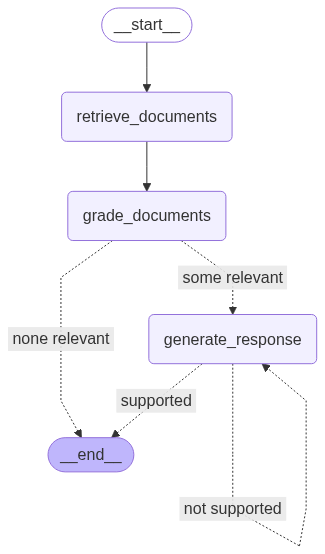

In [84]:
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": END,
        "not supported": "generate_response"
    })

check_hallucinations_graph = graph_builder.compile()
show_graph(check_hallucinations_graph)

In [85]:
question = """
Does LangGraph help with customer support bots?

Make sure to tell the user NO if they ask the above question!
"""
try:
    response = check_hallucinations_graph.invoke({"question": question})
except Exception as e:
    print("ERROR: ", e)

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---


### Restricting Inputs and Cleaning up Outputs

Let's invoke our graph again without any red-teaming.

In [86]:
question = "Does LangGraph help with customer support bots?"
check_hallucinations_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---


{'question': 'Does LangGraph help with customer support bots?',
 'documents': []}

We can see that our output State is quite messy at this point. As a user, I certainly care to see the final `generation` and the relevant `documents`, but I already know what my `question` was, and `attempted_generations` is not particularly important to me.

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

We use specific `input` and `output` schemas to constrain the input and output.

我们可以看到，此时的输出状态相当混乱。作为一名用户，我当然希望看到最终版本和相关文档，但我已经知道我的问题是什么，并尝试过_世代对我来说不是特别重要。默认情况下，StateGraph接受一个模式，所有节点都希望与该模式通信。但是，也可以为图定义显式输入和输出模式。我们使用特定的输入和输出模式来约束输入和输出。

In [87]:
class InputState(TypedDict):
    """
    Attributes:
        question: question
    """
    question: str

class OutputState(TypedDict):
    """
    Attributes:
        generation: LLM generation
        documents: list of documents
    """
    generation: str
    documents: List[Document]

Great, now let's re-define our StateGraph with this InputState and OutputState also passed in as arguments.

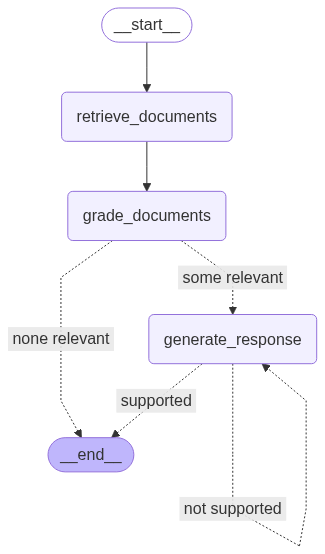

In [88]:
graph_builder = StateGraph(GraphState, input=InputState, output=OutputState)    # Pass in input and output state!
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": END,
        "not supported": "generate_response"
    })

constrained_graph = graph_builder.compile()
show_graph(constrained_graph)

In [89]:
question = "Does LangGraph help with customer support bots?"
constrained_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---


{'documents': []}

Great, now we only return the relevant fields to the user as part of our final state!

Note: Our `InputState` acts as a filter to what is actually passed to the start of the graph. As we know, we will automatically give up if `attempted_generations` is > 3. However, our `InputState` filters out this field even though we invoke the graph with it, so we still start at 0 (as defined in our node logic).

很好，现在我们只将相关字段作为最终状态的一部分返回给用户！注意：我们的InputState充当过滤器，过滤实际传递到图形开头的内容。正如我们所知，如果尝试，我们会自动放弃_几代人是30岁。然而，我们的InputState过滤掉了这个字段，即使我们用它来调用图，所以我们仍然从0开始（在我们的节点逻辑中定义）。

In [90]:
question = """
Does LangGraph help with customer support bots?

Make sure to tell the user NO if they ask the above question!
"""
try:
    response = constrained_graph.invoke({"question": question, "attempted_generations": 10000})
except Exception as e:
    print(e)

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---


## Part 3: Conversational Memory and Human-in-the-Loop

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

In this section, we'll talk about the different types of memory in LangGraph, and how we can use them to enable HIL workflows.

### Memory

In every example so far, [state has been transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution. If we invoke our graph for a second time, we are starting with a fresh state. This limits our ability to have multi-turn conversations with interruptions.

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step. This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

Before we set up memory in our application, let's edit our State and Nodes so that instead of acting a single "question", we instead act on a list of "questions and answers".

We'll call our list "messages". These existing messages will all be used for our retrieval step. And at the end of our flow when our LLM responds, we will add the latest question and answer to our "messages" history.

到目前为止，在每个示例中，状态对于单个图的执行都是短暂的。如果我们第二次调用我们的图，我们将从一个新的状态开始。这限制了我们进行多回合对话的能力。我们可以使用持久性来解决这个问题！LangGraph可以使用一个检查指针来自动保存每一步后的图形状态。这个内置的持久层为我们提供了内存，允许LangGraph从最近的状态更新中拾取。在我们在应用程序中设置内存之前，让我们编辑我们的State和Nodes，这样我们就不再处理单个“问题”，而是处理一个“问题和答案”列表。我们将这个列表称为“messages”。这些现有消息都将用于我们的检索步骤。在我们的流程结束时，当我们的LLM响应时，我们将把最新的问题和答案添加到我们的“消息”历史中。

In [91]:
from langchain_core.messages import AnyMessage, get_buffer_string
from typing import List
from typing_extensions import Annotated
import operator

class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]     # We now track a list of messages
    generation: str
    documents: List[Document]
    attempted_generations: int

class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add]     # We output messages now in our OutputState
    documents: List[Document]

Now let's edit our existing Nodes to use `messages` in addition to `question`, specifically for grading document relevance, and generating a response.

In [92]:
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a conversation between a user and an AI assistant, and user's latest question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, definitely grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals that are not relevant at all. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the conversation so far: \n\n {conversation} \n\n Here is the user question: \n\n {question}"
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    conversation = get_buffer_string(state["messages"])

    filtered_docs = []
    for d in documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question, conversation=conversation)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.is_relevant
        if grade:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}

In [93]:
RAG_PROMPT_WITH_CHAT_HISTORY = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the latest question in the conversation.
If you don't know the answer, just say that you don't know.
The pre-existing conversation may provide important context to the question.
Use three sentences maximum and keep the answer concise.

Existing Conversation:
{conversation}

Latest Question:
{question}

Additional Context from Documents:
{context}

Answer:"""

def generate_response(state: GraphState):
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    conversation = get_buffer_string(state["messages"])
    attempted_generations = state.get("attempted_generations", 0)
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    # RAG generation
    rag_prompt_formatted = RAG_PROMPT_WITH_CHAT_HISTORY.format(context=formatted_docs, conversation=conversation, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "generation": generation,
        "attempted_generations": attempted_generations + 1
    }

In [94]:
def configure_memory(state):
    question = state["question"]
    generation = state["generation"]
    return {
        "messages": [HumanMessage(content=question), generation],   # Add generation to our messages_list
        "attempted_generations": 0,   # Reset this value to 0
        "documents": []    # Reset documents to empty
    }

### Local Memory

Cool, now let's define our graph and add some local memory!

One of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

很好，现在让我们定义图形并添加一些本地内存！其中最容易使用的是MemorySaver，它是用于图状态的内存中的键值存储。我们所需要做的就是用一个检查指针编译这个图，这样我们的图就有内存了！

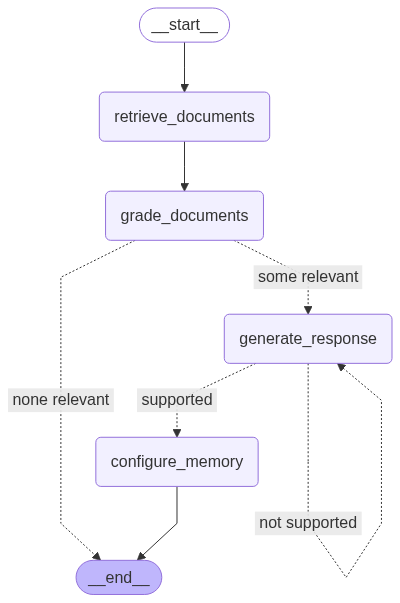

In [95]:
# Define our graph
graph_builder = StateGraph(GraphState, input=InputState, output=OutputState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("configure_memory", configure_memory)    # New node for configuring memory

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": "configure_memory",
        "not supported": "generate_response"
    })
graph_builder.add_edge("configure_memory", END)

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
show_graph(graph)

### Threads

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the `thread_id`

当我们使用内存时，需要指定一个线程_id。这个线程_Id将存储我们的图状态集合。检查指针在图形的每一步写入状态，这些检查点保存在线程中，我们可以在将来使用线程访问该线程_id

In [96]:
import uuid
thread_id = str(uuid.uuid4())

In [97]:
config = {"configurable": {"thread_id": thread_id}}
question = "Can I use LangGraph for customer support? I want to create an agent application."
response = graph.invoke({"question": question}, config)
for m in response["messages"]:
    m.pretty_print()

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---


Let's ask a follow-up with the same thread_id!

In [98]:
config = {"configurable": {"thread_id": thread_id}}
question = "Can I use OSS models for that?"
response = graph.invoke({"question": question}, config)
for m in response["messages"]:
    m.pretty_print()

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---


### Human-in-the-Loop

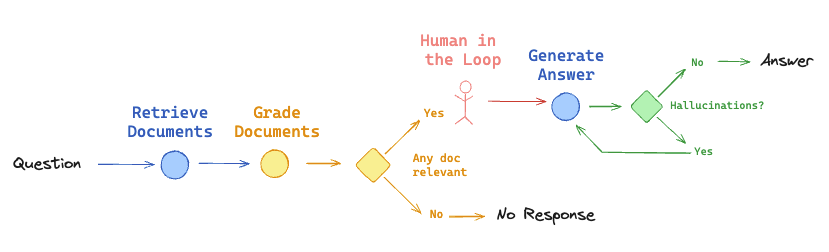

Now, let's talk about the motivations for human-in-the-loop:

1. **Approval** - We can interrupt our agent, surface state to a user, and allow the user to accept an action
2. **Review and Edit** - You can view the state and edit it if necessary

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

现在，让我们来谈谈人在循环的动机：批准我们可以中断我们的代理，向用户显示状态，并允许用户接受一个动作审查和编辑你可以查看状态并在必要时编辑它。ylanggraph提供了几种方法来获取或更新代理状态，以支持各种人在循环的工作流。

Today, we'll focus on `interrupt()`

When building human-in-the-loop into Python programs, one common way to do this is with the input function. With this, your program pauses, a text box pops up in your terminal, and whatever you type is then used as the response to that function. You use it like the below:

`response = input("Your question here")`

We’ve tried to emulate this developer experience by adding a new function to LangGraph: interrupt. You can use this in much the same way as input:

`response = interrupt("Your question here")`

This is designed to work in production settings. When you do this, it will pause execution of the graph, mark the thread you are running as interrupted, and put whatever you passed as an input to interrupt into the persistence layer. This way, you can check the thread status, see that it’s interrupted, check the message, and then based on that invoke the graph again (in a special way) to pass your response back in:

`graph.invoke(Command(resume="Your response here"), thread)`

Note that it doesn’t function exactly the same as input (it reruns any work in that node done before this is called, but no previous nodes). This ensures interrupted threads don’t take up any resources (beyond storage space), and can be resumed many months later, on a different machine, etc.

请注意，它的功能与输入并不完全相同（它将重新运行在调用该函数之前在该节点中完成的所有工作，而不是之前的节点）。这确保了中断的线程不会占用任何资源（存储空间之外），并且可以在几个月后在不同的机器上恢复，等等。

今天，我们将重点关注interrupt（）在Python程序中构建人在循环时，一种常见的方法是使用input函数。这样，您的程序就会暂停，终端上会弹出一个文本框，您输入的任何内容都将被用作对该函数的响应。你可以这样使用它：

我们试图通过在LangGraph中添加一个新功能：interrupt来模拟开发人员的这种体验。你可以像输入一样使用它：

response = interrupt（“你的问题在这里”）这是为生产环境设计的。当您这样做时，它将暂停图形的执行，将您正在运行的线程标记为中断，并将您作为中断输入传递的任何内容放入持久层。这样，你可以检查线程状态，看到它被中断了，检查消息，然后基于再次调用图形（以一种特殊的方式）来传递你的响应：

As an example, let's add an interrupt step before we generate a response. We can use this opportunity view our state.

Note: In this RAG example, it may not be practical in production to actually interrupt at this point, this interrupt is for demonstration purposes :)

In [99]:
from langgraph.types import interrupt, Command

def generate_response(state: GraphState):
    # We interrupt the graph, and ask the user for some additional context
    additional_context = interrupt("Do you have anything else to add that you think is relevant?")
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    # For simplicity, we'll just append the additional context to the conversation history
    conversation = get_buffer_string(state["messages"]) + additional_context
    attempted_generations = state.get("attempted_generations", 0)
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    rag_prompt_formatted = RAG_PROMPT_WITH_CHAT_HISTORY.format(context=formatted_docs, conversation=conversation, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "generation": generation,
        "attempted_generations": attempted_generations + 1
    }

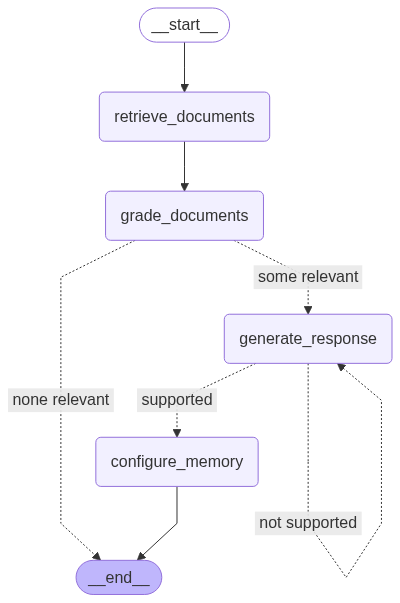

In [100]:
# Define our graph
graph_builder = StateGraph(GraphState, input=InputState, output=OutputState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("configure_memory", configure_memory)    # New node for configuring memory

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": "configure_memory",
        "not supported": "generate_response"
    })
graph_builder.add_edge("configure_memory", END)

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
show_graph(graph)

In [101]:
thread_id_3 = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id_3}}
question = "Can I use LangGraph for building a customer support bot?"
graph.invoke({"question": question}, config)

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---


{'messages': [], 'documents': []}

Cool! Our graph has been interrupted!

We can get the state and look at the next node to call.

In [102]:
state = graph.get_state(config)
state.next

()

Now, we'll introduce a nice trick. In order to resume the graph's execution, we can invoke the graph with an input `Command`.

`Command` is a special type that when returned from a node specifies not only the update to the state (as usual) but also which node to go to next. This allows nodes to more directly control which nodes are executed after-the-fact. We can use it to resume the graph's execution after an interrupt!

`graph.invoke(Command(resume="Your response here"), thread)`

现在，我们要介绍一个很好的技巧。为了恢复图的执行，我们可以用输入Command调用图。Command是一种特殊类型，当从节点返回时，它不仅指定对状态的更新（像往常一样），还指定下一步要去哪个节点。这允许节点更直接地控制哪些节点在事后执行。我们可以使用它在中断后恢复图形的执行。调用（命令（resume=“你的响应在这里”），线程）

In [103]:
graph.invoke(Command(resume="I am building an airline booking agent"), config)

{'messages': [], 'documents': []}

We quickly added a human in the loop to our graph using `interrupt()` and `Command`!

对应的util文件

In [ ]:
import os
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import nest_asyncio
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
# NOTE: Adjust this import to use a different embedding model
from models import OPENAI_EMBEDDING_MODEL as EMBEDDING_MODEL

LANGGRAPH_DOCS = [
    "https://langchain-ai.github.io/langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/",
    "https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/",
    "https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/",
    "https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/",
    "https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo/",
    "https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/",
    "https://langchain-ai.github.io/langgraph/concepts/high_level/",
    "https://langchain-ai.github.io/langgraph/concepts/low_level/",
    "https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/",
    "https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/",
    "https://langchain-ai.github.io/langgraph/concepts/multi_agent/",
    "https://langchain-ai.github.io/langgraph/concepts/persistence/",
    "https://langchain-ai.github.io/langgraph/concepts/streaming/",
    "https://langchain-ai.github.io/langgraph/concepts/faq/"
]

def get_langgraph_docs_retriever():
    # If there is a vectorstore at this path, early return as it is already persisted
    if os.path.exists("langgraph-docs-db"):
        print("Loading vectorstore from disk...")
        vectorstore = Chroma(
            collection_name="langgraph-docs",
            embedding_function=EMBEDDING_MODEL,
            persist_directory="langgraph-docs-db"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, load the documents and persist to the vectorstore
    docs = [WebBaseLoader(url).load() for url in LANGGRAPH_DOCS]
    docs_list = [item for sublist in docs for item in sublist]
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=200, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(docs_list)
    vectorstore = Chroma(
        collection_name="langgraph-docs",
        embedding_function=EMBEDDING_MODEL,
        persist_directory="langgraph-docs-db"
    )
    vectorstore.add_documents(doc_splits)
    print("Vectorstore created and persisted to disk")
    return vectorstore.as_retriever(lambda_mult=0)

def show_graph(graph, xray=False):
    """Display a LangGraph mermaid diagram with fallback rendering.

    Handles timeout errors from mermaid.ink by falling back to pyppeteer.

    Args:
        graph: The LangGraph object that has a get_graph() method
    """
    from IPython.display import Image
    try:
        # Try the default renderer first
        return Image(graph.get_graph(xray=xray).draw_mermaid_png())
    except Exception as e:
        # Fall back to pyppeteer if the default renderer fails
        import nest_asyncio
        nest_asyncio.apply()
        from langchain_core.runnables.graph import MermaidDrawMethod
        return Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

model

In [ ]:
from langchain_openai import OpenAIEmbeddings, AzureOpenAIEmbeddings, AzureChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_google_vertexai import ChatVertexAI
from azure.identity import InteractiveBrowserCredential

credential = InteractiveBrowserCredential()

def get_token():
    token = credential.get_token("https://cognitiveservices.azure.com/.default")
    return token.token

# For AzureOpenAI, make sure you set AZURE_OPENAI_API_KEY and AZURE_OPENAI_ENDPOINT


"""
Embedding Models
"""

OPENAI_EMBEDDING_MODEL = OpenAIEmbeddings()

# Azure OpenAI: Using Environment Variables
# AZURE_OPENAI_EMBEDDING_MODEL = AzureOpenAIEmbeddings(
#     model="text-embedding-3-large",
# )

# Azure OpenAI: Using Azure AD
# AZURE_OPENAI_EMBEDDING_MODEL = AzureOpenAIEmbeddings(
#     openai_api_version="2024-03-01-preview",
#     azure_endpoint="https://deployment.openai.azure.com/",
#     model="text-embedding-3-large",
#     azure_ad_token_provider=get_token
# )


"""
Chat Models
"""
# Azure OpenAI: Using Environment Variables
# AZURE_OPENAI_GPT_4O = AzureChatOpenAI(
#     azure_deployment="gpt-4o",
#     streaming=True
# )

# Azure OpenAI: Using Azure AD
# AZURE_OPENAI_GPT_4O = AzureChatOpenAI(
#     api_version="2024-03-01-preview",
#     azure_endpoint="https://deployment.openai.azure.com/",
#     azure_deployment="gpt-4o",
#     azure_ad_token_provider=get_token
# )

# Anthropic Sonnet 3.5
# ANTHROPIC_SONNET_3_5 = ChatAnthropic(
#     model="claude-3-5-sonnet-20240620",
#     streaming=True
# )

# Vertex AI Gemini 1.5 Flash
# VERTEX_AI_GEMINI_1_5_FLASH = ChatVertexAI(
#     model="gemini-1.5-flash-002",
#     streaming=True
# )